In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs2/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs2/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.5_.55_.85',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_1e-24',
                          'crd_a3d1611',
                          'atmpro_mls')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band04_wn_800_980',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.5_.55_.85',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_1e-24',
                          'crd_a3d1611',
                          'atmpro_mls')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 800

nband = 180

nv = 200

dv = 0.005

tsfc = 294.0

ng = 3

nref = 1

p_refs = (/ 600 /)

t_refs = (/ 250 /)

ng_refs = (/ 3 /)

data wgt
     &     /.5, .55, .85/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 1

klin = 1e-24

include 'mls75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

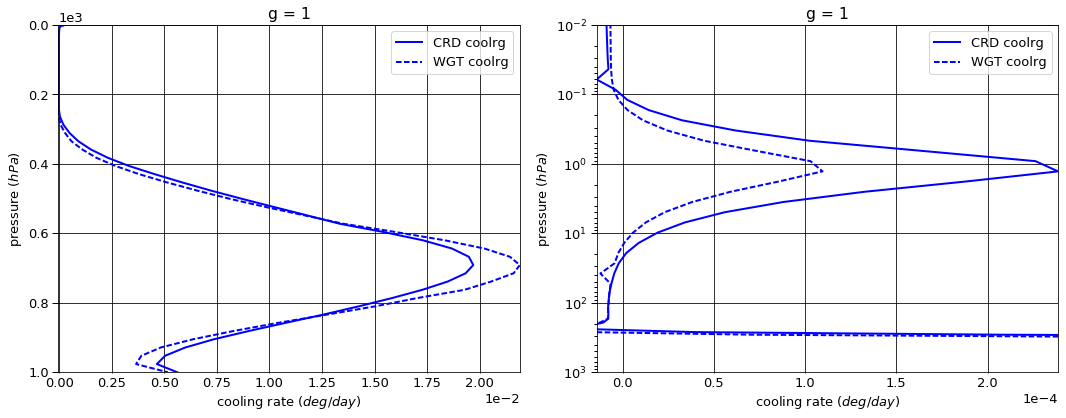

# Figure: cooling rate g-group 2

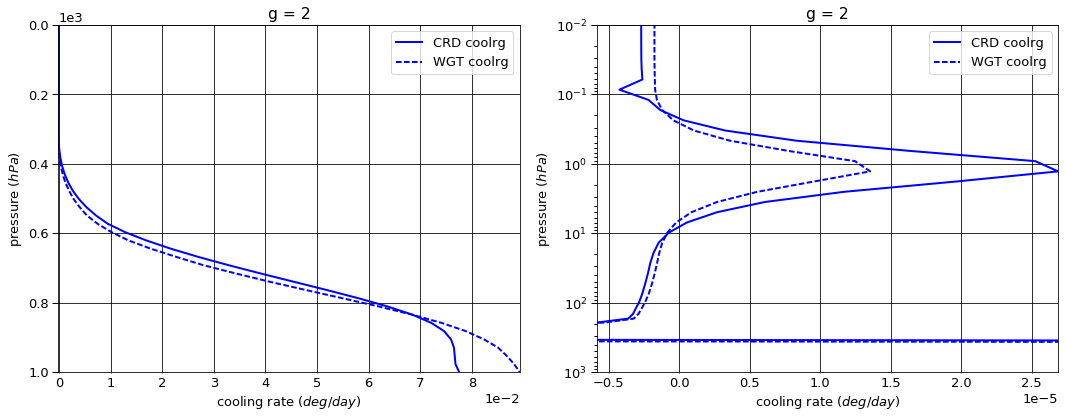

# Figure: cooling rate g-group 3

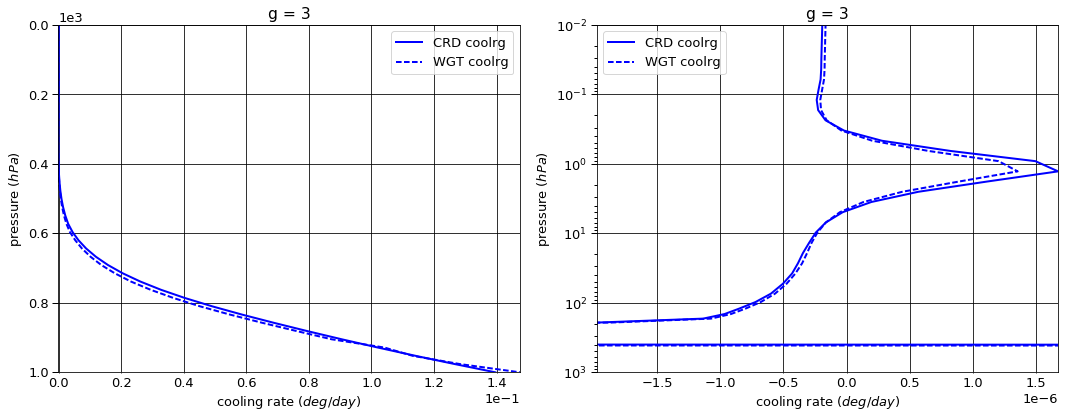

# Figure: cooling rate g-group total

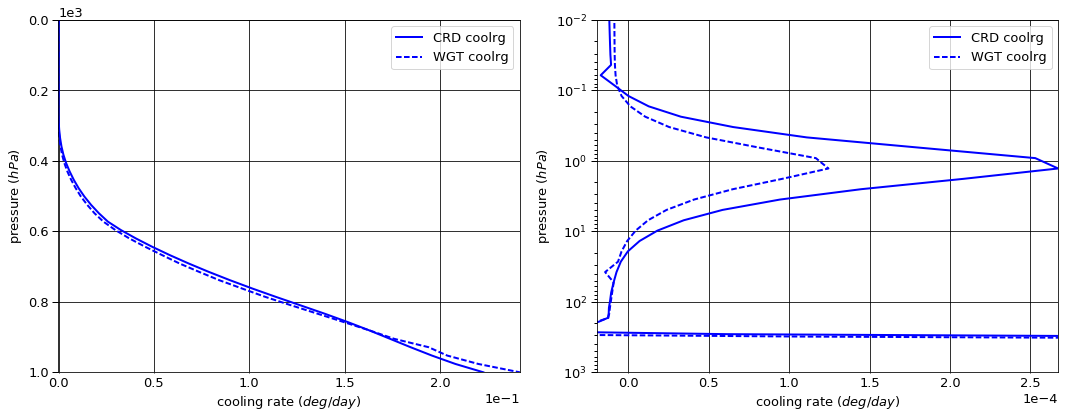

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.898779  0.000000  -0.898779
  1013.0   76     -1.258801  1.225695  -0.033106
2 0.0      1      -4.809476  0.000000  -4.809476
  1013.0   76     -5.313345  3.317964  -1.995382
3 0.0      1     -54.783409  0.000000 -54.783409
  1013.0   76    -55.109100  3.153570 -51.955530


WGT


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.899783  0.000000  -0.899783
  1013.0   76     -1.258801  1.237699  -0.021102
2 0.0      1      -4.850097  0.000000  -4.850097
  1013.0   76     -5.313345  3.300744  -2.012601
3 0.0      1     -54.805615  0.000000 -54.805615
  1013.0   76    -55.109100  3.050277 -52.058823


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001003  0.000000 -0.001003
  1013.0   76     0.000000  0.012004  0.012004
2 0.0      1     -0.040621  0.000000 -0.040621
  1013.0   76     0.000000 -0.017219 -0.017219
3 0.0      1     -0.022206  0.000000 -0.022206
  1013.0   76     0.000000 -0.103293 -0.103293

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -9.812835e-06
  1001.112500 75     5.620699e-03
2 0.000312    1     -2.663492e-06
  1001.112500 75     7.756460e-02
3 0.000312    1     -1.746466e-07
  1001.112500 75     1.395848e-01


WGT


coolrg
g pressure    layer              
1 0.000312    1     -6.852281e-06
  1001.112500 75     5.171920e-03
2 0.000312    1     -1.710837e-06
  1001.112500 75     8.929407e-02
3 0.000312    1     -1.512066e-07
  1001.112500 75     1.474167e-01


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.960554e-06
  1001.112500 75    -4.487791e-04
2 0.000312    1      9.526547e-07
  1001.112500 75     1.172948e-02
3 0.000312    1      2.343991e-08
  1001.112500 75     7.831900e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.491664,0.000000,-60.491664
1013.0,76,-61.681246,7.697229,-53.984017



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.555494,0.000000,-60.555494
1013.0,76,-61.681246,7.588721,-54.092526



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.06383,0.000000,-0.063830
1013.0,76,0.00000,-0.108508,-0.108509


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000013
1001.112500,75,0.222770



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.000009
1001.112500,75,0.241883



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000004
1001.112500,75,0.019113


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.019389,0.020953
2,0.084389,0.087107
3,0.896222,0.891940


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.191856e-23
2,1.000925e-24
3,2.367330e-27


In [21]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [3]
    p_refs = [600]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.191856e-23,NaN,0.019389,0.020953,0.019389,0.020953,600.0
2,1.000925e-24,0.083980,0.084389,0.087107,0.103778,0.108060,600.0
3,2.367330e-27,0.002365,0.896222,0.891940,1.000000,1.000000,600.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog      ratio
layer g                                                    
1     1     0.000312  1.556903e-23  5.362395e-25  29.033718
      2     0.000312  4.875319e-25  1.352671e-26  36.042164
      3     0.000312  2.203556e-27  2.449314e-29  89.966263
2     1     0.000750  1.569115e-23  5.376028e-25  29.187260
      2     0.000750  4.905074e-25  1.356659e-26  36.155531
      3     0.000750  2.224694e-27  2.463775e-29  90.296132
3     1     0.001052  1.595353e-23  5.403197e-25  29.526099
      2     0.001052  4.969276e-25  1.364678e-26  36.413535
      3     0.001052  2.270231e-27  2.488486e-29  91.229405
4     1     0.001476  1.623591e-23  5.432164e-25  29.888477
      2     0.001476  5.038592e-25  1.373189e-26  36.692635
      3     0.001476  2.319524e-27  2.515995e-29  92.191127
5     1     0.002070  1.652336e-23  5.461557e-25  30.253939
      2     0.002070  5.109384e-25  1.381787e-26  36.976637
      3     0.002070  2.370013e-27  2.545614e-29  93.101803
6     1     0.002904  1.681569e-23  5.491579e-25  30.620865
      2     0.002904  5.181610e-25  1.390531e-26  37.263524
      3     0.002904  2.421684e-27  2.578152e-29  93.931000
7     1     0.004074  1.711296e-23  5.522562e-25  30.987351
      2     0.004074  5.255286e-25  1.399517e-26  37.550713
      3     0.004074  2.474575e-27  2.614799e-29  94.637291
8     1     0.005714  1.741522e-23  5.554976e-25  31.350668
      2     0.005714  5.330420e-25  1.408878e-26  37.834501
      3     0.005714  2.528726e-27  2.657242e-29  95.163564
9     1     0.008015  1.772259e-23  5.589489e-25  31.706998
      2     0.008015  5.407023e-25  1.418807e-26  38.109653
      3     0.008015  2.584194e-27  2.707875e-29  95.432559
10    1     0.011243  1.803505e-23  5.627028e-25  32.050757
      2     0.011243  5.485061e-25  1.429571e-26  38.368587
      3     0.011243  2.641024e-27  2.770071e-29  95.341403
11    1     0.015771  1.835257e-23  5.668904e-25  32.374103
      2     0.015771  5.564475e-25  1.441550e-26  38.600646
      3     0.015771  2.699271e-27  2.848583e-29  94.758378
12    1     0.022122  1.867526e-23  5.716976e-25  32.666327
      2     0.022122  5.645217e-25  1.455284e-26  38.791183
      3     0.022122  2.759036e-27  2.950098e-29  93.523550
13    1     0.031031  1.900329e-23  5.773856e-25  32.912650
      2     0.031031  5.727209e-25  1.471532e-26  38.920047
      3     0.031031  2.820457e-27  3.083954e-29  91.455880
14    1     0.043528  1.935847e-23  5.844980e-25  33.119829
      2     0.043528  5.815881e-25  1.491875e-26  38.983707
      3     0.043528  2.887746e-27  3.265196e-29  88.440203
15    1     0.061057  2.044279e-23  5.992306e-25  34.115064
      2     0.061057  6.093366e-25  1.534350e-26  39.713024
      3     0.061057  3.093832e-27  3.585299e-29  86.292159
16    1     0.085645  2.363856e-23  6.317852e-25  37.415496
      2     0.085645  6.942303e-25  1.630628e-26  42.574398
      3     0.085645  3.722861e-27  4.246234e-29  87.674425
17    1     0.120136  2.898381e-23  6.791530e-25  42.676402
      2     0.120136  8.452627e-25  1.783134e-26  47.403203
      3     0.120136  4.855629e-27  5.374807e-29  90.340534
18    1     0.168516  3.564091e-23  7.356212e-25  48.450083
      2     0.168516  1.048824e-24  1.987864e-26  52.761353
      3     0.168516  6.409650e-27  7.064634e-29  90.728692
19    1     0.236378  4.375790e-23  8.072385e-25  54.206903
      2     0.236378  1.319348e-24  2.269904e-26  58.123512
      3     0.236378  8.521280e-27  9.618913e-29  88.588800
20    1     0.331549  5.361490e-23  9.057481e-25  59.194050
      2     0.331549  1.678766e-24  2.672206e-26  62.823232
      3     0.331549  1.141074e-26  1.353389e-28  84.312349
21    1     0.465100  6.552531e-23  1.046850e-24  62.592817
      2     0.465100  2.154631e-24  3.259437e-26  66.104405
      3     0.465100  1.538881e-26  1.954650e-28  78.729226
22    1     0.652400  7.975019e-23  1.247697e-24  63.917900
      2     0.652400  2.776981e-24  4.117210e-26  67

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
